# Figure 1 reproduce
a) Bulid of LW background produced by all stellar populations <br>
b) The SFR for POP 3, neglecting all feedback effects(solid) and after inclusion of LW feedback(dotted) 

## 1) SFR for POP3 (neglecting all feedback effects)
### Constants and Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from scipy.misc import derivative
from scipy.integrate import quad

cosmology.setCosmology('WMAP3')

In [8]:
# WMAP 3-yr results
omega_b = 0.042 # density in baryon
omega_m = 0.24 # density in matter
omega_l = 0.76
omega_r = 1e-5
ro_m=9.9e-30
f_ = 0.001
H_0= 70.4 # km/s/Mpc
h=0.73
    
    # 처음부터  미분 스케일 중요
    # 적분 구간 다를 수 있음 colossuss랑 적분 맞춰주기
    
def H(z): 
    '''
    hubble parameter을 계산해주는 함수
    
    parameters:
                z: np.array() or float
    ----------------------------------------------------
    return: H(z) 
            dtype = float,
            unit: km/s/Mpc)
    '''
    return H_0 * np.sqrt((1+z)**4*omega_r +(1+z)**3*omega_m + omega_l)


def M_crit( z,  T_min=1e3, T_max=1e4, mu=1.2):
    '''
    M_crit 계산 함수
    
    parameters:
                z: float or np.array()
                T_min, T_max, mu: float
    ----------------------------------------------------
    return: 주어진 T에서 z에 따른 min, max M_crit
            dtype = tupple (2*len(z). [0]:M_min , [1]:M_max ),
            unit: solar mass)
    '''
    M_min=1e8*(mu/0.6)**(-3/2)*(T_min/1e4)**(3/2)*((1+z)/10)**(-3/2)
    M_max=1e8*(mu/0.6)**(-3/2)*(T_max/1e4)**(3/2)*((1+z)/10)**(-3/2)
    return M_min, M_max

def f(M, z):
    '''r
    F_col 계산에 쓰일 피적분함수
    
    parameters:
                M: float
                z: float
    ----------------------------------------------------
    return: M * ST halo function (M,z) 계산값
            dtype: np.array
            unit: Solar mass * (Mpc/h)^(-3))
    '''
    n_ST=mass_function.massFunction(M/h, z, q_out='dndlnM', model='sheth99') # unit: (Mpc/h)^(-3)
    return M * n_ST

def F_col(z): # 수정
    '''
    collapsed fraction of mass 계산함수. f를 M에 따라 적분합니다
    
    parameters:
                z: float or np.array()
    ----------------------------------------------------
    return: z에 따른 F_col값 array (z의 함수...)
            dtype: np.array,
            unit: Solar mass * (Mpc/h)^(-3))
    '''

    M_min, M_max= M_crit(z)
    
    if type(z)==float: # z가 flot인 경우
        return 1/ro_m*quad(f,M_min,M_max,args=(z,))[0]
    
    else: # z가 array인 경우
        Farr=[]
        for i in range(len(z)):
            Farr.append(1/ro_m*quad(f,M_min[i],M_max[i],args=(z[i],))[0])
        return np.array(Farr)

def Pop3_SFR(z):
    '''
    star formation rate 계산 함수
    
    parameters:
                z: np.array() or float
    ----------------------------------------------------
    return: z에 따른 Star formation rate array
            dtype: np.array,
            unit: Solar mass * (yr)^(-1) * (Mpc)^(-3)
    '''

    dfdz=derivative(F_col,z)*h**3
    dfdz=derivative(F_col,z)
    dzdt=H(z)/3.086e19*3.17e7*(1+z) # 단위: km/s/Mpc -> yr^-1 # 이것도 맞는 생각일까??
    result=ro_m*omega_b/omega_m*f_*abs(dfdz)*abs(dzdt)
    return result

### code

Text(0, 0.5, 'SFR [$M_\\odot$ $yr^{-1}$ $Mpc^{-3}$]')

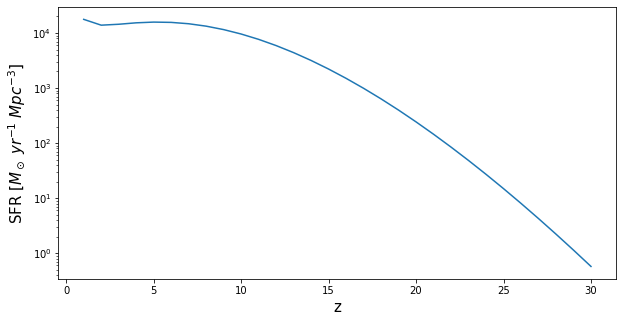

In [10]:
z=np.arange(1.,31.)
plt.figure(figsize=(10,5))
plt.plot(z,Pop3_SFR(z))
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('SFR [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]',fontsize=15)

# order가 이상함
# SFR unit: Solar mass * (yr)^(-1) * (Mpc/h)^(-3)

## 2) Buildup of LW background
### Constants and Functions

In [5]:
eta_LW = 2e4  # number of photons emitted in the LW bands per stellar baryon
h = 6.63e-34 # Plank const., unit: J*s
m_H = 1.67e-27 # proton mass, unit: kg
c = 3e8 # unit: m/s

def ro_star_integ(z):
    '''
    ro_star 피적분함수
    Pop3_SRF * abs(dtdz)
    
    z: float
    ----------------------------------------------------
    return: dtype: float
            unit: Solar mass * (Mpc)^(-3)
    '''
    # print('ro_star_integ is called')    
    dtdz=1/(H(z)/3.086e19*3.17e7*(1+z)) # unit: yr^-1
    return Pop3_SFR(z)*abs(dtdz)

def ro_star(z):
    '''
    (9)번 식
    comoving density in stars. (8)번 식에 들어감
    
    z: float or np.array
    ----------------------------------------------------
    return: dtype: float or np.array
            unit: Solar mass * (Mpc)^(-3)
    '''
    # print('ro_star is called')
    dz=1107/911-1
    arr=[]
    if type(z)==np.ndarray:
        for z_ in z: # 30개의 z에 대해 반복 계산 수행
            z_r=dz+z_
            arr.append(quad(ro_star_integ,z_,z_r)[0]) # 여기서 z가 하나씩 전달됨 
        return np.array(arr)
    else:
        z_r=dz+z
        return quad(ro_star_integ,z,z_r)[0]

def J_LW(z):
    '''
    (8)번 식
    LW flux. J_LW == J_21. z의 함수
    LW flux를 comoving density in star로 나타낸 수식
    
    z: np.array() -> 우리 식에선 1*30
    ----------------------------------------------------
    return: z에 따른 LW flux array
            unit: 1e−21erg/s/cm^2/Hz/sr
    '''
    # print('J_LW is called')
    return h*c/(4*np.pi*m_H)*eta_LW*ro_star(z)*(1+z)**3
# unut: J*m/kg*Solar mass * (Mpc)^(-3)
# Solar mass * m^3 / (s^2 * Mpc^3)
# Solar mass 3.0862e-22 / s^2
# 1.989e+33 * 3.0862e-1 / s^2...

# 이게  1e−21erg/s/cm^2/Hz/sr랑 같은지... (Hz = s^(-1)) (sr: 무차원) (erg: g*cm^2/s^2)
# 1e-21*g/s^2

### code

In [6]:
z=np.arange(1.,31.)

plt.figure(figsize=(10,5))
plt.plot(z,J_LW(z),':')
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('$J_21$',fontsize=15)

Exception: R = 1.40e+10 is too large (max. R = 1.00e+03, max. M = 2.72e+20)

<Figure size 720x360 with 0 Axes>

In [72]:
# unit 맞춰주기 

def J_LW(z):
    '''
    (8)번 식
    LW flux. J_LW == J_21. z의 함수
    LW flux를 comoving density in star로 나타낸 수식
    
    z: np.array() -> 우리 식에선 1*30
    ----------------------------------------------------
    return: z에 따른 LW flux array
            unit: 1e−21erg/s/cm^2/Hz/sr
    '''
    # print('J_LW is called')
    return h*c/(4*np.pi*m_H)*eta_LW*ro_star(z)*(1+z)**3 * 1.989e+33 * 3.0862e-1
# unut: J*m/kg*Solar mass * (Mpc)^(-3)
# Solar mass * m^3 / (s^2 * Mpc^3)
# Solar mass 3.0862e-22 / s^2
# 1.989e+33 * 3.0862e-1 / s^2...??

# 이게  1e−21erg/s/cm^2/Hz/sr (Hz = s^(-1)) (sr: 무차원) (erg: g*cm^2/s^2)
# 1e-21*g/s^2

z=np.arange(1,31)

plt.figure(figsize=(10,5))
plt.plot(z,J_LW(z),':')
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('$J_21$',fontsize=15)

Exception: R = 1.40e+10 is too large (max. R = 1.00e+03, max. M = 2.72e+20)

<Figure size 720x360 with 0 Axes>

## 3) SFR for POP3 (inclusion of LW feedback)

In [59]:
def f_LW(M,z,J):
    '''
    (5)번식
    gas fraction funtion of halo mass and LW flux
    '''
    print('f_LW is called')
    F_21 = 4*np.pi*J
    return 0.06 * np.log(M/(1.25e5+8.7e5*F_21**(0.47))) # unit: x

def f_LW_avg_integ(M,z,J):
    '''
    (6)번식 피적분함수
    '''
    print('f_LW_avg_integ is called')
    h=H(z)/100
    return M * mass_function.massFunction(M/h, z, q_out='dndlnM', model='sheth99') * f_LW(M,z,J)
    
    
def f_LW_avg(z):
    '''
    (6)번식
    '''
    print('f_LW_avg is called')
    M_min, M_max= M_crit(z)
    Farr1=[]
    Farr2=[]
    J = J_LW(z)
    for i in range(len(z)):
        Farr1.append(quad(f_LW_avg_integ,M_min[i],M_max[i],args=(z[i],J[i]))[0])
        Farr2.append(quad(f_LW_avg_integ,M_min[i],M_max[i],args=(z[i],0))[0])
    return np.array(Farr1/Farr2)

def Pop3_SFR_star(z):
    '''
    (7)번식
    '''
    return f_LW_avg(z)*Pop3_SFR(z)

In [60]:
z=np.arange(1,31)
y=Pop3_SFR_star(z) # 시간이 굉장히오래걸림


f_LW_avg is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is cal

f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called
f_LW is called
f_LW_avg_integ is called


TypeError: unsupported operand type(s) for /: 'list' and 'list'

NameError: name 'y' is not defined

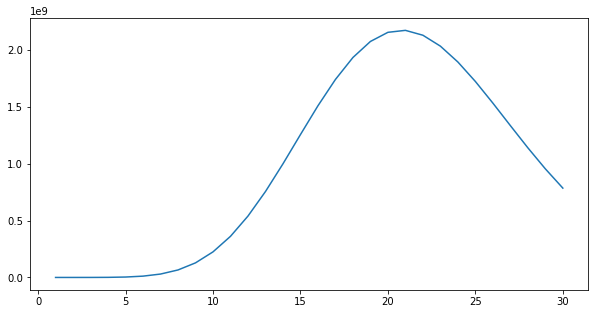

In [62]:
plt.figure(figsize=(10,5))
plt.plot(z,Pop3_SFR(z))
plt.plot(z,y,':')
plt.yscale('log')
plt.xlabel('z',fontsize=15)
plt.ylabel('SFR [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]',fontsize=15)